# Defaults & Charge-off Prediction

## Data Preprocessing

In [154]:
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import numpy as np
from keras.src.callbacks import EarlyStopping
from keras.src.layers import Dense, BatchNormalization, Dropout
from keras.src.models import Sequential
from keras.src.optimizers import Adam
from optuna import visualization as vis
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# load the data
loan3a = pd.read_csv('../data/LoanStats3a_securev1.csv', header=1, low_memory=False)
loan3b = pd.read_csv('../data/LoanStats3b_securev1.csv', header=1, low_memory=False)
loan3c = pd.read_csv('../data/LoanStats3c_securev1.csv', header=1, low_memory=False)
loan3d = pd.read_csv('../data/LoanStats3d_securev1.csv', header=1, low_memory=False)

In [46]:
loan3a

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42533,72176,70868.0,2525.0,2525.0,225.0,36 months,9.33%,80.69,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42534,71623,70735.0,6500.0,6500.0,0.0,36 months,8.38%,204.84,A,A5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42535,70686,70681.0,5000.0,5000.0,0.0,36 months,7.75%,156.11,A,A3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42536,Total amount funded in policy code 1: 471701350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# combine the data
df = pd.concat([loan3a, loan3b, loan3c, loan3d], axis=0)

In [48]:
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421092,36271333,38982739.0,13000.0,13000.0,13000.0,60 months,15.99%,316.07,D,D2,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806,39222577.0,12000.0,12000.0,12000.0,60 months,19.99%,317.86,E,E3,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262,38982659.0,20000.0,20000.0,20000.0,36 months,11.99%,664.20,B,B5,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,Total amount funded in policy code 1: 6417608175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# remove first dataframes from memory
del loan3a
del loan3b
del loan3c
del loan3d

In [50]:
# display all types of loan_status
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Late (31-120 days)',
       'In Grace Period', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

### Drop Unnecessary Variables

In [51]:
# drop the columns that are not needed
df.drop(['id', 'member_id', 'emp_title', 'pymnt_plan', 'url', 'desc', 'title', 'policy_code', 'application_type',
         'annual_inc_joint', 'dti_joint', 'verification_status_joint'], axis=1, inplace=True)

# drop columns with more than 90% missing values
missing_values = df.isnull().mean()
missing_values = missing_values[missing_values > 0.9]

df.drop(missing_values.index, axis=1, inplace=True)

In [52]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421092,13000.0,13000.0,13000.0,60 months,15.99%,316.07,D,D2,5 years,RENT,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,12000.0,12000.0,12000.0,60 months,19.99%,317.86,E,E3,1 year,RENT,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,20000.0,20000.0,20000.0,36 months,11.99%,664.20,B,B5,10+ years,RENT,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert Percentage Columns to Float

In [53]:
# convert int_rate from percentage to float
df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)

# convert revol_util from percentage to float
df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float)

In [54]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421092,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,D2,5 years,RENT,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,E3,1 year,RENT,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,B5,10+ years,RENT,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Handle Missing Values

In [55]:
# for any column starting with 'mths_since', fill missing values with -1
mths_since_columns = [col for col in df.columns if col.startswith('mths_since') or col.startswith('mo_sin')]
df[mths_since_columns] = df[mths_since_columns].fillna(-1)

In [56]:
# for any column starting with total, fill missing values with -1
total_columns = [col for col in df.columns if col.startswith('total') or col.startswith('tot_')]
df[total_columns] = df[total_columns].fillna(-1)

In [57]:
# for any column starting with 'num_', fill missing values with -1
num_columns = [col for col in df.columns if col.startswith('num_')]
df[num_columns] = df[num_columns].fillna(-1)

In [58]:
# for any column starting with 'acc_', fill missing values with -1
acc_columns = [col for col in df.columns if col.startswith('acc_')]
df[acc_columns] = df[acc_columns].fillna(-1)

In [59]:
# for any column starting with 'bc_', fill missing values with -1
bc_columns = [col for col in df.columns if col.startswith('bc_')]
df[bc_columns] = df[bc_columns].fillna(-1)

In [60]:
# for any column starting with 'avg_', fill missing values with -1
avg_columns = [col for col in df.columns if col.startswith('avg_')]
df[avg_columns] = df[avg_columns].fillna(-1)

In [61]:
# for any column starting with 'pct_' or 'percent', fill missing values with -1
pct_columns = [col for col in df.columns if col.startswith('pct_') or 'percent' in col]
df[pct_columns] = df[pct_columns].fillna(-1)

In [62]:
# for mort_acc, fill missing values with -1
df['mort_acc'] = df['mort_acc'].fillna(-1)

In [63]:
# for any nan values in next_pymnt_d, fill with 'No Payment Plan'
df['next_pymnt_d'] = df['next_pymnt_d'].fillna('No Payment Plan')

In [64]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421092,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,D2,5 years,RENT,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,E3,1 year,RENT,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,B5,10+ years,RENT,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,-1.0,-1.0,-1.0,NaN,NaN,-1.0,-1.0,-1.0,-1.0


In [65]:
# drop rows with missing values
df.dropna(inplace=True)

In [66]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421090,10000.0,10000.0,10000.0,36 months,11.99,332.10,B,B5,8 years,RENT,...,0.0,1.0,100.0,100.0,0.0,0.0,32950.0,25274.0,9200.0,15850.0
421091,24000.0,24000.0,24000.0,36 months,11.99,797.03,B,B5,10+ years,MORTGAGE,...,0.0,2.0,56.5,100.0,0.0,0.0,152650.0,8621.0,9000.0,0.0
421092,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,D2,5 years,RENT,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,E3,1 year,RENT,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0


### Convert Target Variable to Binary

In [67]:
# map loan_status to multiple categories
df['loan_status'] = df['loan_status'].map({
    'Fully Paid': 0,
    'Current': 0,
    'In Grace Period': 1,
    'Late (16-30 days)': 2,
    'Late (31-120 days)': 2,
    'Charged Off': 3,
    'Default': 3,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Does not meet the credit policy. Status:Charged Off': 3
})

## Exploratory Data Analysis

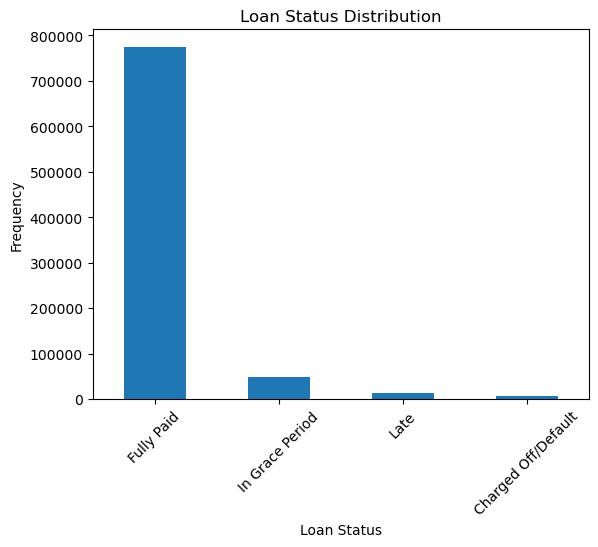

In [68]:
# plot the distribution of loan_status
# change the column names in the plot
df['loan_status'].value_counts().plot(kind='bar')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Fully Paid', 'In Grace Period', 'Late', 'Charged Off/Default'], rotation=45)
plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.title('Loan Status Distribution')
plt.show()

## Feature Engineering

In [69]:
# print data types of all columns
df.dtypes

loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
int_rate                      float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 89, dtype: object

In [70]:
# drop zip code and state columns
df.drop(['zip_code', 'addr_state'], axis=1, inplace=True)

### Dummy Variables

In [71]:
# one hot encoding for categorical variables
df = pd.get_dummies(df, drop_first=True, dtype=int)

In [72]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,...,last_credit_pull_d_Oct-2014,last_credit_pull_d_Oct-2015,last_credit_pull_d_Sep-2008,last_credit_pull_d_Sep-2009,last_credit_pull_d_Sep-2010,last_credit_pull_d_Sep-2011,last_credit_pull_d_Sep-2012,last_credit_pull_d_Sep-2013,last_credit_pull_d_Sep-2014,last_credit_pull_d_Sep-2015
0,5000.0,5000.0,4975.0,10.65,162.87,24000.0,0,27.65,0.0,735.0,...,0,0,0,0,0,0,0,0,0,0
1,2500.0,2500.0,2500.0,15.27,59.83,30000.0,3,1.00,0.0,740.0,...,0,0,0,0,0,0,0,1,0,0
2,2400.0,2400.0,2400.0,15.96,84.33,12252.0,0,8.72,0.0,735.0,...,0,0,0,0,0,0,0,0,0,0
3,10000.0,10000.0,10000.0,13.49,339.31,49200.0,0,20.00,0.0,690.0,...,0,0,0,0,0,0,0,0,0,0
4,3000.0,3000.0,3000.0,12.69,67.79,80000.0,0,17.94,0.0,695.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421090,10000.0,10000.0,10000.0,11.99,332.10,31000.0,0,28.69,0.0,670.0,...,0,0,0,0,0,0,0,0,0,0
421091,24000.0,24000.0,24000.0,11.99,797.03,79000.0,0,3.90,0.0,660.0,...,0,0,0,0,0,0,0,0,0,0
421092,13000.0,13000.0,13000.0,15.99,316.07,35000.0,0,30.90,0.0,680.0,...,0,0,0,0,0,0,0,0,0,0
421093,12000.0,12000.0,12000.0,19.99,317.86,64400.0,2,27.19,1.0,695.0,...,0,0,0,0,0,0,0,0,0,0


### Sampling

In [73]:
# sample 5% of the data
df = df.sample(frac=0.05, random_state=42)

In [74]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,...,last_credit_pull_d_Oct-2014,last_credit_pull_d_Oct-2015,last_credit_pull_d_Sep-2008,last_credit_pull_d_Sep-2009,last_credit_pull_d_Sep-2010,last_credit_pull_d_Sep-2011,last_credit_pull_d_Sep-2012,last_credit_pull_d_Sep-2013,last_credit_pull_d_Sep-2014,last_credit_pull_d_Sep-2015
196734,20000.0,20000.0,20000.0,14.64,472.03,98000.0,0,23.05,0.0,710.0,...,0,0,0,0,0,0,0,0,0,0
126044,12575.0,12575.0,12575.0,28.49,395.26,37000.0,0,13.69,0.0,715.0,...,0,0,0,0,0,0,0,0,0,0
16244,20000.0,20000.0,20000.0,7.29,620.20,86376.0,0,10.85,0.0,745.0,...,0,0,0,0,0,0,0,0,0,0
142209,12925.0,12925.0,12925.0,18.24,329.90,65000.0,0,15.34,2.0,675.0,...,0,0,0,0,0,0,0,0,0,0
130043,18950.0,18950.0,18950.0,15.61,456.91,65000.0,0,9.49,0.0,715.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160052,18375.0,18375.0,18125.0,23.83,526.80,70000.0,3,14.21,0.0,690.0,...,0,0,0,0,0,0,0,0,0,0
379246,14650.0,14650.0,14650.0,17.14,365.20,32000.0,0,23.93,0.0,705.0,...,0,0,0,0,0,0,0,0,0,0
154737,18700.0,18700.0,18700.0,14.99,444.78,43430.0,0,7.99,0.0,795.0,...,0,0,0,0,0,0,0,0,0,0
67008,10000.0,10000.0,10000.0,15.61,349.65,40000.0,0,20.73,1.0,665.0,...,0,0,0,0,0,0,0,0,0,0


### Train-Test Split

In [75]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Feature Scaling

In [78]:
# scale the float columns
scaler = StandardScaler()
float_columns = X_train.select_dtypes(include='float').columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[float_columns] = scaler.fit_transform(X_train[float_columns])
X_test_scaled[float_columns] = scaler.transform(X_test[float_columns])

In [79]:
X_train_scaled

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,last_credit_pull_d_Oct-2014,last_credit_pull_d_Oct-2015,last_credit_pull_d_Sep-2008,last_credit_pull_d_Sep-2009,last_credit_pull_d_Sep-2010,last_credit_pull_d_Sep-2011,last_credit_pull_d_Sep-2012,last_credit_pull_d_Sep-2013,last_credit_pull_d_Sep-2014,last_credit_pull_d_Sep-2015
342143,0.016114,0.017640,0.020764,0.015752,-0.389620,-0.206843,1.003195,-0.362802,0.170568,0.170566,...,0,0,0,0,0,0,0,0,0,0
152631,1.785848,1.788731,1.791022,-1.228543,2.045811,1.068051,0.458126,-0.362802,2.482791,2.482776,...,0,0,0,0,0,0,0,0,0,0
17879,-1.017954,-1.017221,-1.013610,2.090340,-0.815446,-0.194816,0.697956,-0.362802,-0.820384,-0.820381,...,0,0,0,0,0,0,0,0,0,0
136717,-0.633872,-0.632844,-0.629414,-0.261012,-0.503406,-0.519553,0.642238,-0.362802,0.170568,0.170566,...,0,0,0,0,0,0,0,0,0,0
6671,-0.669325,-0.668325,-0.667834,-1.653982,-0.651348,-0.242925,0.868745,-0.362802,2.813108,2.813092,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218496,2.379698,2.383037,2.385049,0.015752,3.058897,0.350274,0.792435,-0.362802,0.335727,0.335724,...,0,0,0,0,0,0,0,0,0,0
30738,-0.338424,-0.337169,-0.334218,0.050062,-0.130270,0.045730,-0.756774,0.769068,-0.490067,-0.490065,...,0,0,0,0,0,0,0,0,0,0
334250,0.016114,0.017640,0.020764,-0.222127,-0.422300,-0.134679,-0.171733,-0.362802,-0.159749,-0.159749,...,0,0,0,0,0,0,0,0,0,0
21083,-0.338424,-0.337169,-0.333878,-1.816381,-0.317699,0.081812,-0.478183,-0.362802,3.308585,3.308565,...,0,0,0,0,0,0,0,0,0,0


## Model Building

### ANN

#### Hyperparameter Optimization

In [173]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)


def objective(trial):
    # Hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    num_units = trial.suggest_int('num_units', 64, 512)
    num_layers = trial.suggest_int('num_layers', 2, 4)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200)

    # Build the model
    model = Sequential()
    model.add(Dense(num_units, activation='relu', input_shape=(X_train_sub.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    for _ in range(num_layers - 1):
        model.add(Dense(num_units // 2, activation='relu'))
        model.add(Dropout(dropout_rate))
        num_units = num_units // 2

    model.add(Dense(num_classes, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Create a callback to stop training if the validation loss does not decrease for 10 epochs
    callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(
        X_train_sub, y_train_sub,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[callback]
    )

    # Get the predicted labels and compute F1-score
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
    f1 = f1_score(y_val, y_pred_classes, average='macro')

    # Report the F1-score to Optuna
    trial.report(f1, step=0)

    # Prune the trial if no improvement
    if trial.should_prune():
        raise optuna.TrialPruned()

    return f1

In [174]:
study = optuna.create_study(direction='maximize')  # Maximize validation accuracy
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Print the best parameters and value
print("Best Parameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)

[I 2024-11-27 10:57:03,553] A new study created in memory with name: no-name-95a322f5-1752-4bc7-aae2-22c2c4e97e63


  0%|          | 0/50 [00:00<?, ?it/s]

/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
[I 2024-11-27 10:57:25,041] Trial 0 finished with value: 0.7061768016563041 and parameters: {'learning_rate': 0.00010567959182433859, 'dropout_rate': 0.4724605657733146, 'num_units': 208, 'num_layers': 2, 'batch_size': 64, 'epochs': 183}. Best is trial 0 with value: 0.7061768016563041.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
[I 2024-11-27 10:58:14,012] Trial 1 finished with value: 0.6736200516471753 and parameters: {'learning_rate': 2.2535826084371247e-05, 'dropout_rate': 0.3426209629110084, 'num_units': 172, 'num_layers': 3, 'batch_size': 64, 'epochs': 192}. Best is trial 0 with value: 0.7061768016563041.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
[I 2024-11-27 10:58:22,256] Trial 2 finished with value: 0.6616702310242625 and parameters: {'learning_rate': 0.0007630571911453246, 'dropout_rate': 0.2539474219983174, 'num_units': 479, 'num_layers': 2, 'batch_size': 128, 'epochs': 111}. Best is trial 0 with value: 0.7061768016563041.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2024-11-27 11:00:18,916] Trial 3 finished with value: 0.673808592355434 and parameters: {'learning_rate': 1.5669995918795293e-05, 'dropout_rate': 0.2705516034084177, 'num_units': 474, 'num_layers': 3, 'batch_size': 32, 'epochs': 91}. Best is trial 0 with value: 0.7061768016563041.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
[I 2024-11-27 11:00:45,241] Trial 4 finished with value: 0.5277734364663544 and parameters: {'learning_rate': 1.233882746672706e-05, 'dropout_rate': 0.4081356283368946, 'num_units': 88, 'num_layers': 2, 'batch_size': 128, 'epochs': 112}. Best is trial 0 with value: 0.7061768016563041.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2024-11-27 11:01:20,488] Trial 5 finished with value: 0.6893994767324714 and parameters: {'learning_rate': 0.00021680982670278863, 'dropout_rate': 0.30831100840248116, 'num_units': 476, 'num_layers': 2, 'batch_size': 32, 'epochs': 116}. Best is trial 0 with value: 0.7061768016563041.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
[I 2024-11-27 11:01:38,208] Trial 6 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
[I 2024-11-27 11:01:44,654] Trial 7 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
[I 2024-11-27 11:01:53,679] Trial 8 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
[I 2024-11-27 11:02:23,834] Trial 9 finished with value: 0.6924011991172591 and parameters: {'learning_rate': 1.9127386810218748e-05, 'dropout_rate': 0.28928836164608507, 'num_units': 115, 'num_layers': 2, 'batch_size': 32, 'epochs': 55}. Best is trial 0 with value: 0.7061768016563041.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
[I 2024-11-27 11:03:06,668] Trial 10 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
[I 2024-11-27 11:03:27,452] Trial 11 finished with value: 0.6898312016554857 and parameters: {'learning_rate': 5.393042324594236e-05, 'dropout_rate': 0.2110917449985131, 'num_units': 69, 'num_layers': 2, 'batch_size': 32, 'epochs': 51}. Best is trial 0 with value: 0.7061768016563041.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
[I 2024-11-27 11:03:44,915] Trial 12 finished with value: 0.6969617403178292 and parameters: {'learning_rate': 0.00010492477553573883, 'dropout_rate': 0.3916286411688963, 'num_units': 167, 'num_layers': 2, 'batch_size': 32, 'epochs': 56}. Best is trial 0 with value: 0.7061768016563041.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
[I 2024-11-27 11:04:00,323] Trial 13 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
[I 2024-11-27 11:04:21,466] Trial 14 finished with value: 0.6902650716485101 and parameters: {'learning_rate': 9.144991953304325e-05, 'dropout_rate': 0.4155407936395407, 'num_units': 360, 'num_layers': 2, 'batch_size': 64, 'epochs': 79}. Best is trial 0 with value: 0.7061768016563041.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2024-11-27 11:05:22,037] Trial 15 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
[I 2024-11-27 11:05:33,225] Trial 16 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
[I 2024-11-27 11:05:56,109] Trial 17 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
[I 2024-11-27 11:07:17,765] Trial 18 finished with value: 0.6973788587303884 and parameters: {'learning_rate': 3.1050425118004285e-05, 'dropout_rate': 0.4965527494057965, 'num_units': 366, 'num_layers': 2, 'batch_size': 32, 'epochs': 135}. Best is trial 0 with value: 0.7061768016563041.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[I 2024-11-27 11:08:34,192] Trial 19 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[I 2024-11-27 11:10:47,981] Trial 20 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
[I 2024-11-27 11:11:37,174] Trial 21 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
[I 2024-11-27 11:12:04,651] Trial 22 finished with value: 0.7177507569744426 and parameters: {'learning_rate': 0.0001542058247543865, 'dropout_rate': 0.36785790810881586, 'num_units': 220, 'num_layers': 2, 'batch_size': 32, 'epochs': 135}. Best is trial 22 with value: 0.7177507569744426.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
[I 2024-11-27 11:12:17,512] Trial 23 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[I 2024-11-27 11:12:31,909] Trial 24 finished with value: 0.7044281718623153 and parameters: {'learning_rate': 0.0003684178843399891, 'dropout_rate': 0.42815961500031163, 'num_units': 224, 'num_layers': 2, 'batch_size': 32, 'epochs': 152}. Best is trial 22 with value: 0.7177507569744426.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
[I 2024-11-27 11:12:40,871] Trial 25 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2024-11-27 11:13:05,845] Trial 26 finished with value: 0.7111130701732818 and parameters: {'learning_rate': 0.0003478778915883664, 'dropout_rate': 0.4245946317850171, 'num_units': 243, 'num_layers': 2, 'batch_size': 32, 'epochs': 155}. Best is trial 22 with value: 0.7177507569744426.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
[I 2024-11-27 11:13:28,297] Trial 27 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[I 2024-11-27 11:13:54,698] Trial 28 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
[I 2024-11-27 11:14:03,445] Trial 29 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2024-11-27 11:14:33,934] Trial 30 finished with value: 0.6944199018556992 and parameters: {'learning_rate': 0.00030422515111939107, 'dropout_rate': 0.4278001718958978, 'num_units': 192, 'num_layers': 2, 'batch_size': 64, 'epochs': 167}. Best is trial 22 with value: 0.7177507569744426.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2024-11-27 11:15:25,085] Trial 31 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[I 2024-11-27 11:16:10,589] Trial 32 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
[I 2024-11-27 11:16:36,484] Trial 33 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2024-11-27 11:17:21,997] Trial 34 finished with value: 0.7016645680668566 and parameters: {'learning_rate': 7.258813250199087e-05, 'dropout_rate': 0.42284143521613465, 'num_units': 162, 'num_layers': 2, 'batch_size': 32, 'epochs': 125}. Best is trial 22 with value: 0.7177507569744426.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
[I 2024-11-27 11:17:38,913] Trial 35 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
[I 2024-11-27 11:17:54,614] Trial 36 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[I 2024-11-27 11:18:27,830] Trial 37 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[I 2024-11-27 11:18:52,446] Trial 38 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
[I 2024-11-27 11:19:10,181] Trial 39 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
[I 2024-11-27 11:19:26,205] Trial 40 finished with value: 0.7096945335312749 and parameters: {'learning_rate': 0.00017459904251030772, 'dropout_rate': 0.4581596274507175, 'num_units': 184, 'num_layers': 2, 'batch_size': 64, 'epochs': 167}. Best is trial 22 with value: 0.7177507569744426.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
[I 2024-11-27 11:19:40,975] Trial 41 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2024-11-27 11:20:36,364] Trial 42 finished with value: 0.7009021418437456 and parameters: {'learning_rate': 0.00013216638220745784, 'dropout_rate': 0.45437704682952657, 'num_units': 252, 'num_layers': 2, 'batch_size': 64, 'epochs': 159}. Best is trial 22 with value: 0.7177507569744426.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
[I 2024-11-27 11:21:05,465] Trial 43 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[I 2024-11-27 11:22:12,627] Trial 44 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2024-11-27 11:22:46,542] Trial 45 finished with value: 0.7074759895186242 and parameters: {'learning_rate': 0.0003808436470809785, 'dropout_rate': 0.4105740481493732, 'num_units': 505, 'num_layers': 2, 'batch_size': 64, 'epochs': 162}. Best is trial 22 with value: 0.7177507569744426.


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
[I 2024-11-27 11:23:51,128] Trial 46 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
[I 2024-11-27 11:24:05,699] Trial 47 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[I 2024-11-27 11:24:24,745] Trial 48 pruned. 


/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
[I 2024-11-27 11:26:00,708] Trial 49 pruned. 
Best Parameters: {'learning_rate': 0.0001542058247543865, 'dropout_rate': 0.36785790810881586, 'num_units': 220, 'num_layers': 2, 'batch_size': 32, 'epochs': 135}
Best Validation Accuracy: 0.7177507569744426


In [175]:
# Visualizations
vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()

#### Model Training

In [176]:
best_params = study.best_params
num_classes = len(y_train.unique())

In [177]:
# Build the final model with best parameters
ann_model = Sequential()
ann_model.add(Dense(best_params['num_units'], activation='relu', input_shape=(X_train_scaled.shape[1],)))
ann_model.add(BatchNormalization())
ann_model.add(Dropout(best_params['dropout_rate']))

for _ in range(best_params['num_layers'] - 1):
    ann_model.add(Dense(best_params['num_units'] // 2, activation='relu'))
    ann_model.add(Dropout(best_params['dropout_rate']))
    best_params['num_units'] = best_params['num_units'] // 2

ann_model.add(Dense(num_classes, activation='softmax'))

/opt/anaconda3/envs/FINA4390/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [178]:
# compile the model
ann_model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [179]:
# create a callback to stop training if the validation loss does not decrease for 10 epochs
callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [180]:
# fit the model
history = ann_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=1000, batch_size=64,
                        callbacks=[callback])

Epoch 1/1000
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8238 - loss: 0.5409 - val_accuracy: 0.9736 - val_loss: 0.1052
Epoch 2/1000
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9683 - loss: 0.1210 - val_accuracy: 0.9784 - val_loss: 0.0763
Epoch 3/1000
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9746 - loss: 0.0898 - val_accuracy: 0.9811 - val_loss: 0.0677
Epoch 4/1000
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9782 - loss: 0.0790 - val_accuracy: 0.9810 - val_loss: 0.0691
Epoch 5/1000
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9809 - loss: 0.0627 - val_accuracy: 0.9820 - val_loss: 0.0657
Epoch 6/1000
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9823 - loss: 0.0629 - val_accuracy: 0.9827 - val_loss: 0.0633
Epoch 7/1000
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9845 - loss: 0.0557 - val_accuracy: 0.9832 - val_loss: 0.0632
Epoch 8/1000
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9858 - loss: 0.0450 - 

In [186]:
# print model summary
ann_model.summary()

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_452 (Dense)               │ (None, 220)            │       265,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_124         │ (None, 220)            │           880 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_327 (Dropout)           │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_453 (Dense)               │ (None, 110)            │        24,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_328 (Dropout)           │ (None, 110)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 4)              │           444 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 871,984 (3.33 MB)

 Trainable params: 290,514 (1.11 MB)

 Non-trainable params: 440 (1.72 KB)

 Optimizer params: 581,030 (2.22 MB)

#### Model Evaluation

In [184]:
# print classification report
y_pred_proba = ann_model.predict(X_test_scaled)
y_pred = y_pred_proba.argmax(axis=1)

print(classification_report(y_test, y_pred))

394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11650
           1       0.38      0.04      0.07        81
           2       0.82      0.73      0.77       172
           3       0.98      0.95      0.96       698

    accuracy                           0.98     12601
   macro avg       0.79      0.68      0.70     12601
weighted avg       0.98      0.98      0.98     12601



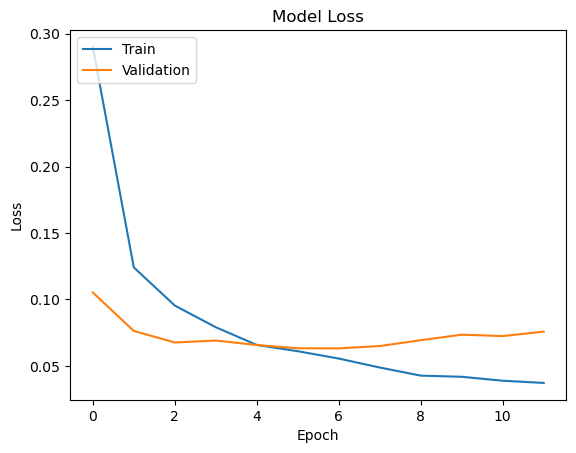

In [185]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()